In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
os.environ["GCR_CONFIG_SOURCE"]="files"
from astropy.cosmology import FlatLambdaCDM
import GCR
import GCRCatalogs as GCRCat
import numpy as np
import sys
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(ROOT_DIR)
import pandas as pd
from matplotlib.lines import Line2D
import itertools
from itertools import permutations 
from itertools import product 
import utils.utils as ut
import healpy as hp
import astropy
import astropy.units as u
import astropy.cosmology.units as cu
# import bilby as bb


# cosmo = FlatLambdaCDM(H0=70, Om0=0.283, Tcmb0=2.725)

plt.rcParams.update({

    # --- Figure Layout ---
    "figure.figsize": (6, 4),           # Default figure size in inches
    "figure.dpi": 150,                  # DPI for crisp rendering
    "savefig.dpi": 300,                 # Higher DPI for saved figures
    "figure.autolayout": True,          # Avoids label overlap

    # --- Font & Text ---
    "font.family": "monospace",             # Or "sans-serif" for modern look
    "font.serif": ["Terminal"],  # Matches many journals
    "font.size": 12,                    # Base font size
    "axes.titlesize": 14,               # Title font size
    "axes.labelsize": 13,               # Axis label size
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "mathtext.fontset": "dejavuserif",  # Matches the serif font

    # --- Line & Marker Styles ---
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.7,

    # --- Axes ---
    "axes.linewidth": 1.0,              # Frame thickness
    "axes.labelpad": 6,                 # Padding between label and axis
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.spines.top": False,           # Removes top spine
    "axes.spines.right": False,         # Removes right spine

    # --- Ticks ---
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.top": False,
    "ytick.right": False,

    # --- Legend ---
    "legend.frameon": False,
    "legend.handlelength": 2,
    "legend.handletextpad": 0.4,
    "legend.loc": "best",

    # --- Colors and Colormaps ---
    "image.cmap": "viridis",            # Good perceptually uniform default
    "axes.prop_cycle": plt.cycler("color", [
        "#1f77b4", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]),
})

In [2]:
NSIDE=128

In [3]:
npix = hp.nside2npix(NSIDE)

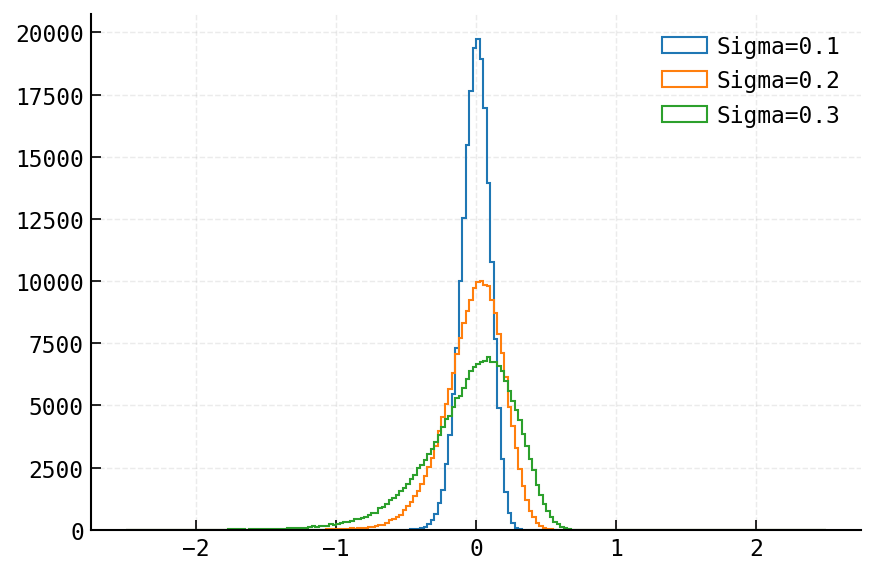

In [4]:
for sig in [0.1,0.2,0.3]:
    counts = -np.random.lognormal(mean=0,sigma=sig,size=npix)
    # counts = np.log10(counts)
    counts -= np.median(counts)
    # print(np.max(counts))
    plt.hist(counts,bins=np.arange(-2.5,2.51,step=0.025),label=f"Sigma={sig}",histtype='step')
plt.legend()

## Four cuts needed

- Mag-depth cut
- Survey uniformity cut
- z_true - z_measured adjustment for different photo-z/spec-z cases
- Cosmology adjustments to z, if needed

### Let's start with the general magnitude-limiting cut

In [5]:
LSST_bands = ["u","g","r","i","z","Y"]
visits_per_yr = np.array([56, 74, 184, 187, 166, 171])/10 # visits per year in u-g-r-i-z-y

visits_dict = {}
for band,vis in zip(LSST_bands,visits_per_yr):
    visits_dict[band] = vis

expTimes = [38,30,30,30,30,30]
 
eTime_dict = {}
for band,eTime in zip(LSST_bands,expTimes):
    eTime_dict[band] = eTime

In [6]:
key_years = [1,4,7,10]
airmass = 1.2
myQuantitiesOfInterest = np.array(["redshift_true","ra_true","dec_true", # These are rest frame absolute mags, de-reddened
                                   "Mag_true_u_lsst_z0_no_host_extinction",
                                   "Mag_true_g_lsst_z0_no_host_extinction",
                                   "Mag_true_r_lsst_z0_no_host_extinction",
                                   "Mag_true_i_lsst_z0_no_host_extinction",
                                   "Mag_true_z_lsst_z0_no_host_extinction",
                                   "Mag_true_Y_lsst_z0_no_host_extinction",
                                   "mag_true_u_lsst_no_host_extinction",
                                   "mag_true_g_lsst_no_host_extinction",
                                   "mag_true_r_lsst_no_host_extinction",
                                   "mag_true_i_lsst_no_host_extinction",
                                   "mag_true_z_lsst_no_host_extinction",
                                   "mag_true_Y_lsst_no_host_extinction",
                                   "galaxyID","is_central"])

In [7]:
z_step=0.025
z_max = 1.2

In [8]:
for year in key_years:
    limiting_mags = {}
    for band in LSST_bands:
        C_m,m_sky,theta_eff,k_m = ut.getLSSTBandParameters(band)
        limiting_mags[band] = ut.LSST_mag_lim(C_m,m_sky,theta_eff,eTime_dict[band]*visits_dict[band]*year,k_m,airmass)

In [9]:
cat_name2 = "skysim5000_v1.2_small"
skysimCat = GCRCat.load_catalog(cat_name2)

In [10]:
# for k in skysimCat.list_all_quantities():
#     if k.__contains__("lsst"):
#         print(k)

In [11]:
filters,filter_distribution = ut.GCR_filter_overlord(year,LSST_bands,eTime_dict,visits_dict)

In [12]:
%%time
data = pd.DataFrame(skysimCat.get_quantities(list(myQuantitiesOfInterest),filters=tuple(filters)))
data[f"hp_ind_nside{NSIDE}"] = ut.RaDecToIndex(data['ra_true'],data['dec_true'],NSIDE).astype(np.int32) # Add 

CPU times: user 6.09 s, sys: 4.01 s, total: 10.1 s
Wall time: 14.7 s


In [13]:
data

,Mag_true_r_lsst_z0_no_host_extinction,Mag_true_g_lsst_z0_no_host_extinction,Mag_true_i_lsst_z0_no_host_extinction,galaxyID,redshift_true,mag_true_Y_lsst_no_host_extinction,mag_true_u_lsst_no_host_extinction,ra_true,mag_true_z_lsst_no_host_extinction,Mag_true_u_lsst_z0_no_host_extinction,mag_true_g_lsst_no_host_extinction,mag_true_r_lsst_no_host_extinction,Mag_true_Y_lsst_z0_no_host_extinction,is_central,mag_true_i_lsst_no_host_extinction,dec_true,Mag_true_z_lsst_z0_no_host_extinction,hp_ind_nside128
0,-19.490667,-19.170687,-19.641598,10070000000000,0.021528,15.057467,16.832254,62.583876,15.118994,-18.130419,15.692865,15.361683,-19.774324,True,15.194109,-40.333731,-19.720839,162471
1,-16.130363,-15.799252,-16.299818,10070000000001,0.020944,18.329252,19.871372,61.398113,18.393080,-14.983802,19.000322,18.660936,-16.442663,True,18.478420,-41.036333,-16.384882,162984
2,-19.664007,-19.306858,-19.851128,10070000000002,0.020528,14.705607,16.474499,60.844522,14.777728,-18.356327,15.451198,15.082397,-20.023260,True,14.886256,-40.442012,-19.957903,161961
3,-16.518398,-16.075336,-16.736721,10070000000003,0.017873,17.500126,19.509354,61.418679,17.577370,-15.005349,18.383389,17.927797,-16.926462,True,17.698551,-39.964143,-16.854864,161960
4,-17.320200,-17.022739,-17.488804,10070000000004,0.001106,10.715576,12.118320,61.945086,10.780575,-16.253250,11.348219,11.050673,-17.655111,True,10.881983,-39.925337,-17.590200,161448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6454488,-18.255322,-18.289740,-18.240658,9943101895670,1.170968,25.401423,25.911562,66.018447,25.470118,-17.899406,25.973698,26.022394,-18.242260,True,26.000237,-39.888156,-18.231886,161442
6454489,-19.429482,-19.368925,-19.456999,9943101895709,1.160954,24.329454,26.033625,65.998919,24.475386,-18.701132,25.865328,25.592409,-19.483679,True,25.292122,-39.081505,-19.463242,160418
6454490,-18.561619,-18.628283,-18.528393,9943101895720,1.157497,25.033072,25.305576,65.842693,25.048487,-18.325918,25.400488,25.489635,-18.506886,True,25.511377,-37.648455,-18.505604,158370
6454491,-17.711115,-18.002914,-17.520699,9943101895736,1.152863,25.609697,25.109047,65.974418,25.462534,-18.091755,25.279688,25.482374,-17.316826,True,25.659170,-39.973771,-17.404568,161442


In [14]:
data.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454493 entries, 0 to 6454492
Data columns (total 18 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Mag_true_r_lsst_z0_no_host_extinction  float32
 1   Mag_true_g_lsst_z0_no_host_extinction  float32
 2   Mag_true_i_lsst_z0_no_host_extinction  float32
 3   galaxyID                               int64  
 4   redshift_true                          float64
 5   mag_true_Y_lsst_no_host_extinction     float32
 6   mag_true_u_lsst_no_host_extinction     float32
 7   ra_true                                float64
 8   mag_true_z_lsst_no_host_extinction     float32
 9   Mag_true_u_lsst_z0_no_host_extinction  float32
 10  mag_true_g_lsst_no_host_extinction     float32
 11  mag_true_r_lsst_no_host_extinction     float32
 12  Mag_true_Y_lsst_z0_no_host_extinction  float32
 13  is_central                             bool   
 14  mag_true_i_lsst_no_host_extinction     float32
 15

In [15]:
lum_dist = skysimCat.cosmology.luminosity_distance(data['redshift_true'])

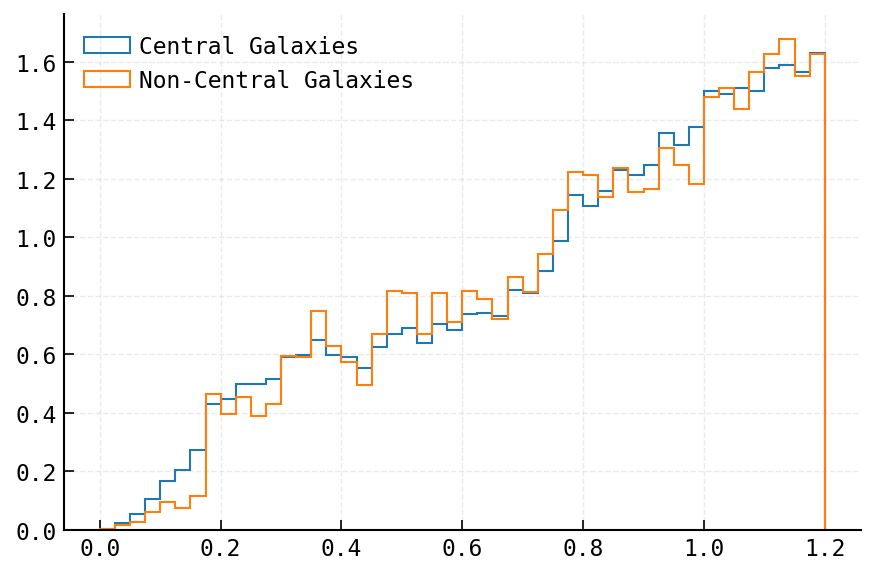

In [16]:
fig,ax = plt.subplots()

histVals = ax.hist(data[data["is_central"]==True]["redshift_true"],histtype="step",density=True,
                   bins=np.arange(0,z_max+z_step,step=z_step),label="Central Galaxies")
histVals = ax.hist(data[data["is_central"]==False]["redshift_true"],histtype="step",density=True,
                   bins=np.arange(0,z_max+z_step,step=z_step),label="Non-Central Galaxies")
ax.legend()

### Compute new redshifts for fixed $d_L$ under different cosmologies

In [17]:
# Generate a random permutation of indices
p = np.random.permutation(len(data["redshift_true"]))

In [18]:
n_points = 10000

In [19]:
data.iloc[p[0:n_points]]

,Mag_true_r_lsst_z0_no_host_extinction,Mag_true_g_lsst_z0_no_host_extinction,Mag_true_i_lsst_z0_no_host_extinction,galaxyID,redshift_true,mag_true_Y_lsst_no_host_extinction,mag_true_u_lsst_no_host_extinction,ra_true,mag_true_z_lsst_no_host_extinction,Mag_true_u_lsst_z0_no_host_extinction,mag_true_g_lsst_no_host_extinction,mag_true_r_lsst_no_host_extinction,Mag_true_Y_lsst_z0_no_host_extinction,is_central,mag_true_i_lsst_no_host_extinction,dec_true,Mag_true_z_lsst_z0_no_host_extinction,hp_ind_nside128
2362995,-15.308947,-15.105158,-15.410418,9559000016519,0.191373,24.227268,25.656857,65.553011,24.256981,-14.409337,24.883905,24.477196,-15.473194,True,24.337320,-34.585512,-15.445809,154275
2882553,-18.632935,-18.610083,-18.644875,9686000796625,0.972116,24.697086,26.062727,62.736357,24.698202,-18.016541,25.951529,25.697182,-18.657429,True,25.095387,-35.950696,-18.640827,156327
6182938,-23.187941,-22.888964,-23.360451,9816101927985,1.108514,20.718670,22.448654,68.109329,21.009718,-22.000771,22.396584,22.151165,-23.576031,True,21.724152,-37.692972,-23.485504,158367
43792,-18.047373,-17.616917,-18.239019,10070000065796,0.376939,23.002825,26.332497,61.434044,23.129274,-16.468651,24.914356,23.709789,-18.379309,False,23.327276,-40.227878,-18.323526,161960
487470,-17.478117,-17.519617,-17.459791,10071000716995,0.924742,25.704582,26.133652,64.410473,25.662783,-17.144520,26.235088,26.260546,-17.458685,True,25.827391,-39.167105,-17.449354,160932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5412502,-18.399675,-18.430656,-18.387808,10327101789492,1.162030,25.245779,25.881062,68.667599,25.316280,-18.000698,25.925495,25.947176,-18.399517,True,25.892933,-44.719266,-18.384758,167475
3706265,-19.034758,-18.929459,-19.086910,9815000816015,0.986012,24.392374,26.412050,64.329809,24.454288,-18.161472,26.186739,25.723394,-19.138508,True,24.985769,-36.838865,-19.108807,157860
5715153,-20.371708,-20.229120,-20.448833,9686101988470,1.096654,23.332058,24.326101,64.370005,23.485300,-19.594563,24.381174,24.328665,-20.519922,True,24.069370,-35.611734,-20.487700,155812
2584310,-17.706474,-17.765255,-17.678474,9559000714109,0.953597,25.523445,25.821053,64.468663,25.475780,-17.444544,25.931702,25.993462,-17.661766,True,25.662983,-34.700184,-17.657475,154276


In [20]:
%%time
h_05_redshift = ut.transmute_redshift(data.iloc[p[0:n_points]]["redshift_true"],skysimCat.cosmology,alternate_h=0.5)
h_10_redshift = ut.transmute_redshift(data.iloc[p[0:n_points]]["redshift_true"],skysimCat.cosmology,alternate_h=1)

CPU times: user 35.6 s, sys: 283 ms, total: 35.9 s
Wall time: 35.9 s


CPU times: user 35.3 ms, sys: 91.3 ms, total: 127 ms
Wall time: 126 ms


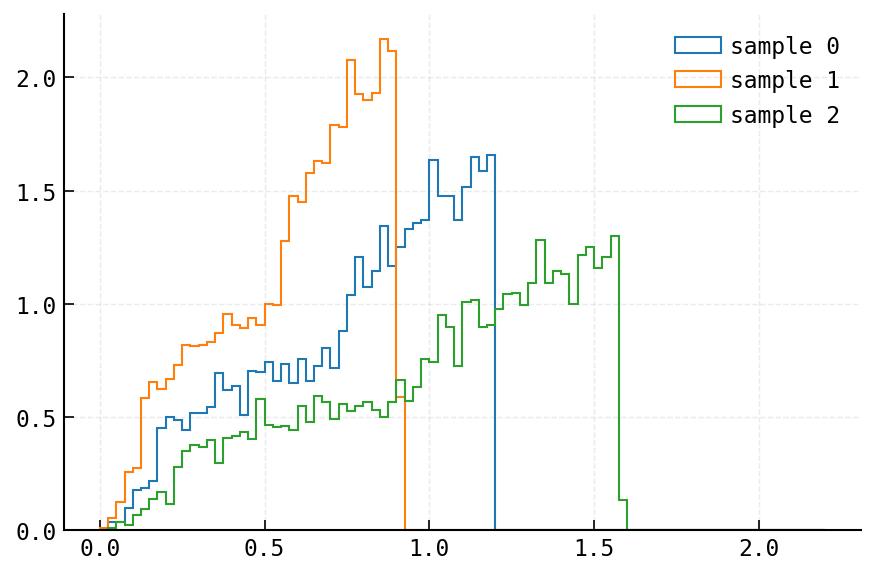

In [21]:
%%time
n=0
fig,ax = plt.subplots()
for d in [data.iloc[p[0:n_points]]['redshift_true'],h_05_redshift,h_10_redshift]:
    histVals = ax.hist(d,histtype="step",density=True,
                       bins=np.arange(0,z_max+1+z_step,step=z_step),label=f"sample {n}")
    # histVals = ax.hist(d[data[0:n_points]["is_central"]==False],histtype="step",density=True,
    #                    bins=np.arange(0,z_max+z_step,step=z_step),label="Non-Central Galaxies")
    n+=1
ax.legend()
fig.show()

The above works, but is slow ...

### Test the healpix non-uniformity functions

#### Mock band adjustment script

In [22]:
hp_uniq_ids = np.unique(data["hp_ind_nside128"])
n_adjustments = len(hp_uniq_ids)
sigma=0.2

In [23]:
%%time

hp_band_dict = ut.getHp_band_dict(hp_uniq_ids,LSST_bands,sigma,NSIDE,limiting_mags)
data = ut.dropFaintGalaxies(data,hp_uniq_ids,LSST_bands,hp_band_dict)

In [24]:
data.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
Index: 4529231 entries, 0 to 6454490
Data columns (total 18 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Mag_true_r_lsst_z0_no_host_extinction  float32
 1   Mag_true_g_lsst_z0_no_host_extinction  float32
 2   Mag_true_i_lsst_z0_no_host_extinction  float32
 3   galaxyID                               int64  
 4   redshift_true                          float64
 5   mag_true_Y_lsst_no_host_extinction     float32
 6   mag_true_u_lsst_no_host_extinction     float32
 7   ra_true                                float64
 8   mag_true_z_lsst_no_host_extinction     float32
 9   Mag_true_u_lsst_z0_no_host_extinction  float32
 10  mag_true_g_lsst_no_host_extinction     float32
 11  mag_true_r_lsst_no_host_extinction     float32
 12  Mag_true_Y_lsst_z0_no_host_extinction  float32
 13  is_central                             bool   
 14  mag_true_i_lsst_no_host_extinction     float32
 15  dec

In [30]:
for band in LSST_bands:
    _max = 0
    for ind in hp_band_dict.keys():
        if hp_band_dict[ind][band]>_max:
            _max = hp_band_dict[ind][band]
    print(f"Max for {band} band is {_max:.2f}, compared to limiting mag of {limiting_mags[band]:.2f}")

Max for u band is 26.45, compared to limiting mag of 26.00
Max for g band is 27.60, compared to limiting mag of 27.11
Max for r band is 27.59, compared to limiting mag of 27.16
Max for i band is 27.13, compared to limiting mag of 26.74
Max for z band is 26.55, compared to limiting mag of 26.10
Max for Y band is 25.64, compared to limiting mag of 25.20


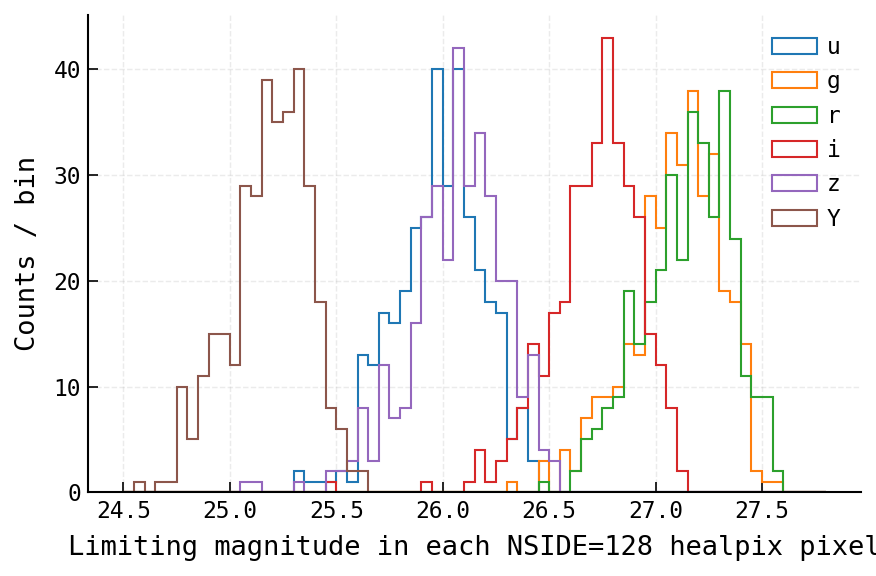

In [40]:
fig,ax = plt.subplots()
for band in LSST_bands:
    limits = []
    for ind in hp_band_dict.keys():
        limits.append(hp_band_dict[ind][band])
    ax.hist(limits,histtype="step",density=False,
                       bins=np.arange(24.5,27.8,step=0.05),label=f"{band}")
ax.legend()
ax.set_xlabel(f"Limiting magnitude in each NSIDE={NSIDE} healpix pixel")
ax.set_ylabel("Counts / bin")

plt.show()

The survey nonuniformity cut works

### Photo-z/spec-z redshift precision

In [43]:
data["photoz_unmodeled"] = ut.trueZ_to_photoZ(data["redshift_true"],10)
data["photoz_modeled"] = ut.trueZ_to_photoZ(data["redshift_true"],10,modeled=True)

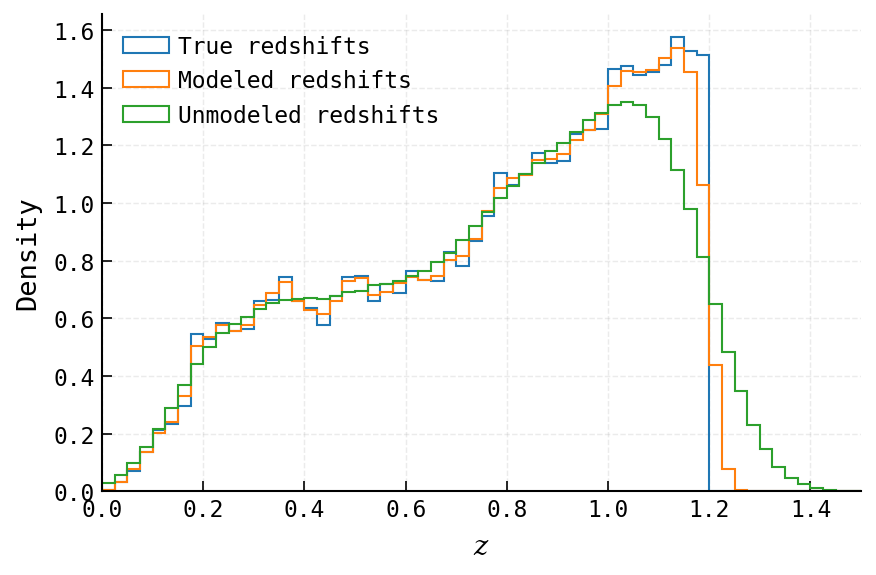

In [48]:
fig,ax = plt.subplots()
for d,lbl in zip([data['redshift_true'],data['photoz_modeled'],data['photoz_unmodeled']],["True","Modeled","Unmodeled"]):
    histVals = ax.hist(d,histtype="step",density=True,
                       bins=np.arange(0,z_max+1+z_step,step=z_step),label=f"{lbl} redshifts")
ax.set_xlim(0,1.5)
ax.set_xlabel("$z$")
ax.set_ylabel("Density")
ax.legend()